# Test di Pearson

In [74]:
import os
import math
from pandas import *
import pandas as pd
from datetime import datetime
%matplotlib inline 
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

os.getcwd()
os.chdir("/Users/riccardo/Dropbox/A-Data/Paperopoli")
data = pd.read_csv('PluviometriaPaperopoli_4.txt')
map(datetime,data['anno'])
data=data.set_index('anno')

In [75]:
data[-5:]

,1h,3h,6h,12h,24h
anno,,,,,
1984,61.2,61.4,61.4,62.6,81.8
1985,23.6,35.6,44.2,58.6,69.8
1986,20.2,36.8,51.4,55.8,74.4
1987,32.6,40.6,64.6,77.2,81.2
1988,89.2,102.0,102.0,102.0,104.2


In [76]:
from scipy.stats import norm
from scipy.stats import genextreme,gumbel_r
from numpy import linspace
from pylab import plot,show,hist,figure,title

In [77]:
abs_m=pd.read_pickle("abs_m")
abs_mq=pd.read_pickle("abs_mq")
abs_mle=pd.read_pickle("abs_mle")

In [78]:
abs_m

,1h,3h,6h,12h,24h
a,31.241689,39.187045,48.028038,60.753736,75.683743
b,9.823556,10.694365,13.272078,18.313274,23.986088


In [79]:
abs_mq

,1h,3h,6h,12h,24h
a,31.740980,40.176970,48.436261,61.722079,73.471566
b,8.003627,11.459221,16.938302,25.040592,23.685827


In [80]:
abs_mle

,1h,3h,6h,12h,24h
a,31.59042,39.527315,48.100316,60.562103,75.848891
b,9.07316,10.041456,12.398915,18.005471,22.435148


https://docs.scipy.org/doc/scipy-0.18.1/reference/tutorial/stats.html

In [81]:
print(gumbel_r.__doc__)

A right-skewed Gumbel continuous random variable.

    As an instance of the `rv_continuous` class, `gumbel_r` object inherits from it
    a collection of generic methods (see below for the full list),
    and completes them with details specific for this particular distribution.
    
    Methods
    -------
    ``rvs(loc=0, scale=1, size=1, random_state=None)``
        Random variates.
    ``pdf(x, loc=0, scale=1)``
        Probability density function.
    ``logpdf(x, loc=0, scale=1)``
        Log of the probability density function.
    ``cdf(x, loc=0, scale=1)``
        Cumulative distribution function.
    ``logcdf(x, loc=0, scale=1)``
        Log of the cumulative distribution function.
    ``sf(x, loc=0, scale=1)``
        Survival function  (also defined as ``1 - cdf``, but `sf` is sometimes more accurate).
    ``logsf(x, loc=0, scale=1)``
        Log of the survival function.
    ``ppf(q, loc=0, scale=1)``
        Percent point function (inverse of ``cdf`` --- percentiles).
  

In [82]:
abs_m.at["a","1h"]

31.241689405642404

In [83]:
rv=gumbel_r(loc=abs_m.at["a","1h"],scale=abs_m.at["b","1h"])
rv

In [84]:
q=[0.2,0.4,0.6,0.8,1]
h1h=rv.ppf(q)
h1h

array([ 26.56680635,  32.10048014,  37.84043735,  45.97643435,          inf])

In [85]:
ecdf1h = ECDF(data["1h"])
r=ecdf1h(h1h)
r

array([ 0.16,  0.34,  0.62,  0.84,  1.  ])

In [86]:
l1h=len(data["1h"])
l1h

50

Ci si aspetta che, in ogni intervallo, con limite destro h1h, ci siano $e=(l1h * q)$ elementi mentre ce ne sono  in realtà $o=(l1h * r)$.  La formula dell'$X^2$ è allora:
\begin{equation}
X^2 = \frac{1}{e}\sum_{i=1}^k (e - o)^2
\end{equation}

In [87]:
o0=l1h*r
o0

array([  8.,  17.,  31.,  42.,  50.])

In [88]:
o=o0-np.append([0],np.delete(o0,-1))
o

array([  8.,   9.,  14.,  11.,   8.])

In [89]:
range(len(r))

range(0, 5)

In [90]:
e=[0.2*l1h for i in range(len(r))]
e

[10.0, 10.0, 10.0, 10.0, 10.0]

In [91]:
o-e

array([-2., -1.,  4.,  1., -2.])

In [92]:
(o-e)**2

array([  4.,   1.,  16.,   1.,   4.])

In [93]:
(o-e)**2/e

array([ 0.4,  0.1,  1.6,  0.1,  0.4])

In [94]:
((o-e)**2/e).sum()

2.6000000000000045

In [95]:
def X2(data,abs_t,h,delta):    
    dt=data[h].dropna()
    #print(dt)
    lh=len(dt)
    #print("lh: ",lh)
    q=[delta*(i+1) for i in range(int(1/delta))]
    #print("q: ",q)
    rv=gumbel_r(loc=abs_t.at["a",h],scale=abs_t.at["b",h])
    ecdf = ECDF(dt)
    r=ecdf(rv.ppf(q))
    #print("r: ",r)
    o0=lh*r
    #print("o0: ",o0)
    o=o0-np.append([0],np.delete(o0,-1))
    #print("o: ",o)
    e=[delta*lh for i in range(len(r))]
    #print("e: ",e)
    return ((o-e)**2/e).sum()  

In [96]:
X2(data,abs_m,"1h",0.2)

2.6000000000000045

In [97]:
X2(data,abs_mq,"1h",0.2)

0.79999999999999782

In [98]:
X2(data,abs_mle,"1h",0.2)

1.8000000000000023

In [99]:
for  h in data.columns:
    print(h,": ",[X2(data,abs_m,h,0.2),X2(data,abs_mq,h,0.2),X2(data,abs_mle,h,0.2)])

1h :  [2.6000000000000045, 0.79999999999999782, 1.8000000000000023]
3h :  [2.2222222222222223, 6.222222222222225, 2.6666666666666665]
6h :  [4.2222222222222152, 7.1111111111111125, 3.3333333333333259]
12h :  [3.1111111111111085, 2.8888888888888888, 3.7777777777777697]
24h :  [0.66666666666666674, 0.88888888888888884, 1.1111111111111112]


In [100]:
    delta=0.2
    h="12h"
    abs_t=abs_mle
    ###
    dt=data[h].dropna()
    #print(dt)
    lh=len(dt)
    print("lh: ",lh)
    q=[delta*(i+1) for i in range(int(1/delta))]
    print("q: ",q)
    rv=gumbel_r(loc=abs_t.at["a",h],scale=abs_t.at["b",h])
    ecdf = ECDF(dt)
    r=ecdf(rv.ppf(q))
    print("r: ",r)
    o0=lh*r
    print("o0: ",o0)
    o=o0-np.append([0],np.delete(o0,-1))
    print("o: ",o)
    e=[delta*lh for i in range(len(r))]
    print("e: ",e)
    print("(o-e): ",(o-e))
    print("(o-e)^2: ",(o-e)**2)
    ((o-e)**2/e[0]).sum()   

lh:  45
q:  [0.2, 0.4, 0.6000000000000001, 0.8, 1.0]
r:  [ 0.28888889  0.42222222  0.6         0.75555556  1.        ]
o0:  [ 13.  19.  27.  34.  45.]
o:  [ 13.   6.   8.   7.  11.]
e:  [9.0, 9.0, 9.0, 9.0, 9.0]
(o-e):  [ 4. -3. -1. -2.  2.]
(o-e)^2:  [ 16.   9.   1.   4.   4.]


3.7777777777777697

In [101]:
abs_t.at["a","24h"]

75.848890849512259

In [102]:
abs_mle

,1h,3h,6h,12h,24h
a,31.59042,39.527315,48.100316,60.562103,75.848891
b,9.07316,10.041456,12.398915,18.005471,22.435148


In [103]:
abs_mle.columns

Index(['1h', '3h', '6h', '12h', '24h'], dtype='object')

In [104]:
abs_mle.columns=["1h","3h","6h","12h","24h"]

In [105]:
a=[]
for  h in data.columns:
    a=a+[[X2(data,abs_m,h,0.2),X2(data,abs_mq,h,0.2),X2(data,abs_mle,h,0.2)]]
   
pd.DataFrame(a,index=["1h","3h","6h","12h","24h"],columns=["M","Mq","MLE"])

,M,Mq,MLE
1h,2.600000,0.800000,1.800000
3h,2.222222,6.222222,2.666667
6h,4.222222,7.111111,3.333333
12h,3.111111,2.888889,3.777778
24h,0.666667,0.888889,1.111111


La strategia è di costruire un DataFrame dei parametri migliori. 

In [106]:
best=DataFrame([abs_mq["1h"],
                abs_m["3h"],
                abs_mle["6h"],
                abs_mq["12h"],
                abs_m["24h"]]).T
                  
best

,1h,3h,6h,12h,24h
a,31.740980,39.187045,48.100316,61.722079,75.683743
b,8.003627,10.694365,12.398915,25.040592,23.986088


In [107]:
best.to_pickle("best_param")

In [108]:
from scipy.stats import genextreme,gumbel_r
from numpy import linspace
from statsmodels.distributions.empirical_distribution import ECDF
def gumbel(x,abs_d,col):
    return np.exp(-np.exp(-(x-abs_d[col]["a"])/abs_d[col]["b"]))
t_rain=np.linspace(data.min()[0],data.max()[4],100)

In [109]:
gb=pd.DataFrame([gumbel(t_rain,best,"1h"),
                 gumbel(t_rain,best,"3h"),
                 gumbel(t_rain,best,"6h"),
                 gumbel(t_rain,best,"12h"),
                 gumbel(t_rain,best,"24h")]).T
gb.index=t_rain
gb.columns=["1h","3h","6h","12h","24"]
gb[-5:]

,1h,3h,6h,12h,24
19.600000,0.010481,0.001943,0.000047,0.004621,0.000032
21.113131,0.022982,0.004428,0.000148,0.006334,0.000060
22.626263,0.044021,0.009053,0.000408,0.008523,0.000108
24.139394,0.075388,0.016841,0.001001,0.011270,0.000189
25.652525,0.117678,0.028865,0.002213,0.014661,0.000319
27.165657,0.170129,0.046079,0.004467,0.018780,0.000521
28.678788,0.230826,0.069156,0.008318,0.023709,0.000828
30.191919,0.297142,0.098378,0.014421,0.029526,0.001277
31.705051,0.366228,0.133589,0.023469,0.036301,0.001919
33.218182,0.435411,0.174226,0.036115,0.044092,0.002813


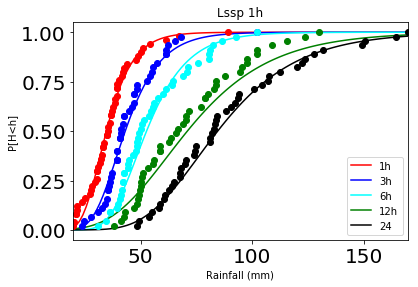

In [110]:
plt.rc('xtick', labelsize=20) #Quest  comandi globali
plt.rc('ytick', labelsize=20) #Questi sono comandi globali
ax=gb.plot(color=["red","blue","cyan","green","black"])
ecdf1h = ECDF(data["1h"])
ax.plot(data["1h"],ecdf1h(data["1h"]),'o',c="red")
data3h=data["3h"].dropna()
ecdf3h = ECDF(data3h)
ax.plot(data3h,ecdf3h(data3h),"o",c="blue")
data6h=data["6h"].dropna()
ecdf6h = ECDF(data6h)
ax.plot(data6h,ecdf6h(data6h),"o",c="cyan")
data12h=data["12h"].dropna()
ecdf12h = ECDF(data12h)
ax.plot(data12h,ecdf12h(data12h),"o",c="green")
data24h=data["24h"].dropna()
ecdf24h = ECDF(data24h)
ax.plot(data24h,ecdf24h(data24h),"o",c="black")
ax.set_title('Lssp 1h')
ax.set_xlabel('Rainfall (mm)')
ax.set_ylabel('P[H<h]')